In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
from torch_scatter import scatter_mean
import torchvision.transforms as T

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from datasets import MP3dPSP

In [13]:
torch.manual_seed(3985)
ds = MP3dPSP('val')
pilimg = T.ToPILImage()

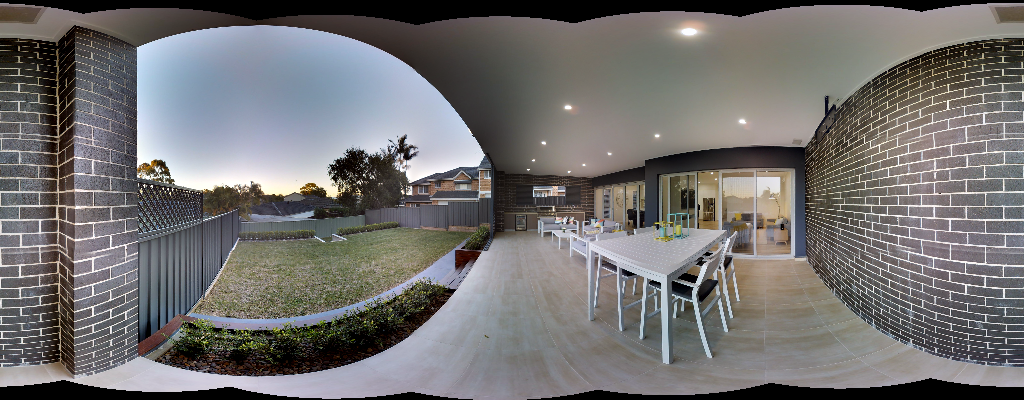

In [14]:
x = ds[0][0]
pilimg(x)

In [7]:
from numpy import pi as PI
from patch_ops import TangentPatch, polar_coord_grid

In [8]:
patch_dim = 16
npatch = 1024
fov = 2.0 * np.pi / np.ceil(np.sqrt(npatch * 1024.0 / 400.0))
device = 'cuda:0'

In [9]:
theta, phi = polar_coord_grid(fov, patch_dim, npatch)
theta, phi = map(lambda x: x.to(device), (theta, phi))
tan_patch = TangentPatch(theta, phi).to(device)

In [10]:
xb = x.to(device)
patch = tan_patch(xb.unsqueeze(0)).squeeze(0)
patch.shape

torch.Size([3, 1024, 16, 16])

In [11]:
x_coord = (theta / PI + 1.0) * 1023 / 2.0
y_coord = (-phi / PI + 0.5) * 399

In [12]:
x_coord = x_coord.round().long()
y_coord = y_coord.round().long()

In [13]:
x_coord = x_coord.flatten(0, 1).unsqueeze(0)
y_coord = y_coord.flatten(0, 1).unsqueeze(0)
y_coord = scatter_mean(y_coord, x_coord, dim_size=1024)

In [14]:
patch_flat = patch.flatten(1, 2)

In [15]:
patch_flat2 = scatter_mean(
    patch_flat, x_coord.expand_as(patch_flat), dim_size=1024
)

In [16]:
patch_flat3 = scatter_mean(
    patch_flat2, y_coord, dim_size=400, dim=-2
)

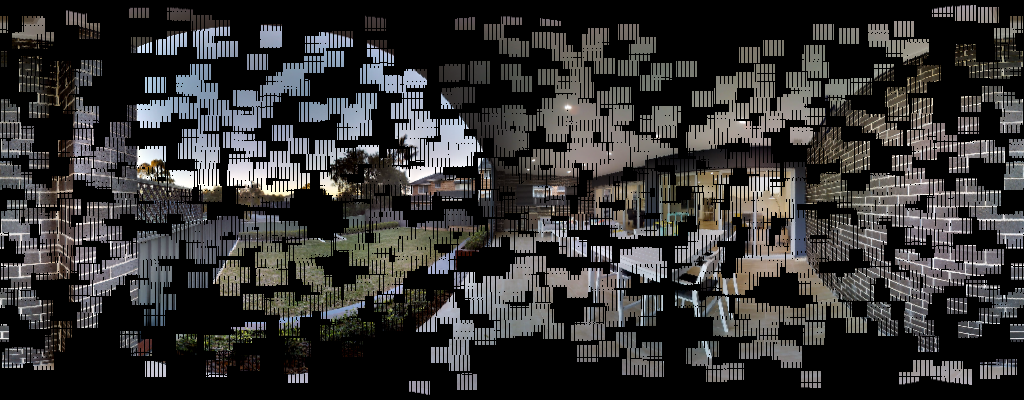

In [17]:
pilimg(patch_flat3.to('cpu'))

---

In [1]:
import torch
import numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader
from numpy import pi as PI

In [2]:
torch.manual_seed(3985)
pilimg = T.ToPILImage()

In [4]:
from datasets import MP3dPSP
from model.patch_ops import TangentPatch, Scatter2D, polar_coord_grid

In [5]:
ds = MP3dPSP('val')
dl = DataLoader(ds, batch_size=4)

In [6]:
patch_dim = 16
npatch = 864
# fov = 2.0 * PI / np.ceil(np.sqrt(npatch * 1024.0 / 400.0))
fov = 5.0 * PI / 180.0

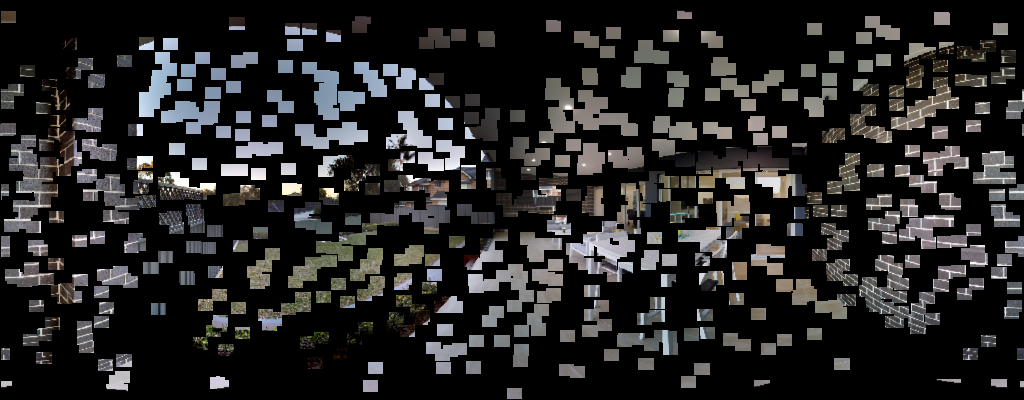

In [8]:
device = 'cuda:0'

grid = polar_coord_grid(fov, patch_dim, npatch)
x_grid, y_grid = map(lambda x: x.to(device), grid)

tan_patch = TangentPatch(x_grid, y_grid).to(device)
scatter2d = Scatter2D(x_grid, y_grid, 400, 1024).to(device)

xb, _ = next(iter(dl))
xb = xb.to(device)
patch = tan_patch(xb)
patch_img = scatter2d(patch)

pilimg(patch_img.to('cpu')[0, ...])

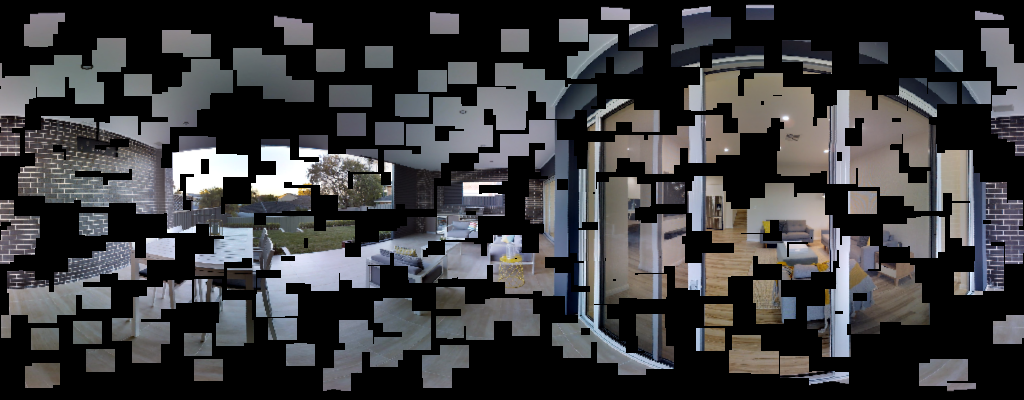

In [14]:
pilimg(patch_img.to('cpu')[3, ...])

---

In [ ]:
from tangent_patch import TangentPatch, create_polar_coord_grid

In [ ]:
patch_dim = 32
npatch = 420
fov = 2.0 * np.pi / np.sqrt(npatch * 1024.0 / 400.0)
tan_patch = TangentPatch(fov, patch_dim, npatch)

In [ ]:
patch = tan_patch(x.unsqueeze(0)).squeeze(0)
theta, phi = tan_patch.theta, tan_patch.phi

In [ ]:
theta.shape, phi.shape

In [ ]:
# theta: [-pi, pi] -> [0, 1023], phi: [pi/2, -pi/2] -> [0, 399]
x_coord = torch.round((theta / np.pi + 1.0) * 1023.0 / 2.0).long()
y_coord = torch.round((-phi / np.pi + 0.5) * 399.0).long()

In [ ]:
# x_coord = x_coord.unsqueeze(1)
# y_coord = y_coord.unsqueeze(1)
y_coord = scatter_mean(y_coord, x_coord)

In [ ]:
x_coord.shape, y_coord.shape

In [ ]:
patch2 = scatter_mean(patch, x_coord.expand_as(patch), dim_size=1024)
patch3 = scatter_mean(patch2, y_coord.expand_as(patch2), dim=-2, dim_size=400)

In [ ]:
patch4 = patch3.sum(dim=0) / (patch3 != 0).sum(dim=0)
pilimg(patch4)